<a href="https://colab.research.google.com/github/senthilkumar-dimitra/LULC-Classification-DL/blob/expts/LULC_L8_L9_GeoPointsData_using_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install some packages
!pip install rasterio -q
!pip install earthpy -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 9.4 MB/s eta 0:00:00


In [3]:
# Import packages
import pandas as pd
import numpy as np
import keras
from keras import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten, Input, GlobalMaxPooling1D
from keras.callbacks import EarlyStopping
from keras import Model
import rasterio
import earthpy.plot as ep
from keras.utils import to_categorical, plot_model, model_to_dot
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import from_levels_and_colors

In [4]:
# Parameter
FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'EVI', 'NBR', 'NDMI', 'NDWI', 'NDBI', 'NDBaI', 'elevation']
LABEL = ['classvalue']
SPLIT = ['sample']
N_CLASSES = 9
CLASSES = [0, 1, 2, 3, 4, 5, 6, 7, 8]
PALETTE = ['#F08080', '#D2B48C', '#87CEFA', '#008080', '#90EE90', '#228B22', '#808000', '#FF8C00', '#006400']
SAMPLE_PATH = '/content/drive/MyDrive/OG_DL/Samples_LC_Jambi_2023_points.csv'
IMAGE_PATH = '/content/drive/MyDrive/OG_DL/Landsat_Jambi_2023_points.tif'

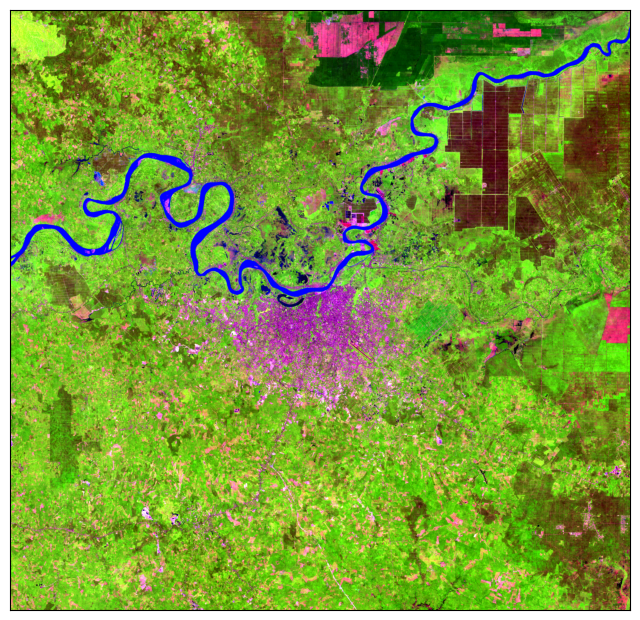

<Axes: >

In [5]:
# Load image
image = rasterio.open(IMAGE_PATH)
bandNum = image.count
height = image.height
width = image.width
crs = image.crs
transform = image.transform
shape = (height, width)

image_vis = []
for x in [6, 5, 4]:
  image_vis.append(image.read(x))
image_vis = np.stack(image_vis)

plot_size = (8, 8)
ep.plot_rgb(
  image_vis,
  figsize=plot_size,
  stretch=True,
)

In [6]:
# Read sample
samples = pd.read_csv(SAMPLE_PATH)
samples = samples.sample(frac = 1) # Shuffle data
samples

,B1,B2,B3,B4,B5,B6,B7,EVI,NBR,NDMI,NDWI,NDBI,NDBaI,elevation,classvalue,sample
433,0.010677,0.012575,0.035070,0.020866,0.255895,0.093961,0.038081,0.456622,0.740923,0.462858,-0.758940,-0.462858,0.423197,8,8,train
16,0.062914,0.069803,0.096945,0.112702,0.215470,0.250972,0.204181,0.187783,0.026900,-0.076113,-0.379383,0.076113,0.102803,27,0,train
133,0.053839,0.073501,0.151477,0.187241,0.106295,0.024359,0.015545,-0.120565,0.744829,0.627125,0.175281,-0.627125,0.220875,14,2,train
245,0.040350,0.049837,0.087705,0.071068,0.378572,0.271653,0.138827,0.537147,0.463365,0.164435,-0.623808,-0.164435,0.323585,50,4,train
9,0.069500,0.074972,0.098403,0.115287,0.213407,0.247370,0.193277,0.182673,0.049498,-0.073707,-0.368830,0.073707,0.122757,12,0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,0.020605,0.026132,0.052312,0.037957,0.347855,0.190637,0.080720,0.561569,0.623310,0.291959,-0.738547,-0.291959,0.405065,24,6,train
37,0.040350,0.050305,0.077970,0.076265,0.220695,0.210520,0.142237,0.277537,0.216177,0.023596,-0.477877,-0.023596,0.193568,27,0,train
321,0.028305,0.034850,0.072553,0.052808,0.420510,0.245665,0.112895,0.622811,0.576701,0.262461,-0.705707,-0.262461,0.370287,59,6,train
441,0.011007,0.015187,0.041120,0.026408,0.273715,0.090785,0.038480,0.469006,0.753487,0.501866,-0.738784,-0.501866,0.404634,9,8,train


In [7]:
# Split into train and test based on column
train = samples[samples['sample'] == 'train']
test = samples[samples['sample'] == 'test']

# Split between features and label
train_features = train[FEATURES]
train_label = train[LABEL]
test_features = test[FEATURES]
test_label = test[LABEL]

# Convert samples dataframe (pandas) to numpy array
train_input = train_features.to_numpy()
test_input = test_features.to_numpy()

# Make label data categorical
train_output = to_categorical(train_label.to_numpy() - 1, N_CLASSES)
test_output = to_categorical(test_label.to_numpy() - 1, N_CLASSES)

# Show the data shape
print(f'Train features: {train_input.shape}\nTest features: {test_input.shape}\nTrain label: {train_output.shape}\nTest label: {test_output.shape}')


Train features: (381, 14)
Test features: (93, 14)
Train label: (381, 9)
Test label: (93, 9)


In [8]:
# Create MLP model
model = Sequential([
    Dense(256, activation='relu', input_shape=(len(FEATURES),)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(N_CLASSES, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               3840      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 9)                 5

In [9]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Create callback to stop training if loss not decreasing
stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Fit the model
result = model.fit(
    x=train_input, y=train_output,
    validation_data=(test_input, test_output),
    batch_size=32,
    callbacks=[stop],
    epochs=100,
)

Epoch 1/100
12/12 [==============================] - 6s 102ms/step - loss: 2.7923 - accuracy: 0.1181 - val_loss: 2.1431 - val_accuracy: 0.1613
Epoch 2/100
12/12 [==============================] - 0s 26ms/step - loss: 2.3219 - accuracy: 0.1470 - val_loss: 2.1352 - val_accuracy: 0.1613
Epoch 3/100
12/12 [==============================] - 0s 24ms/step - loss: 2.2970 - accuracy: 0.1076 - val_loss: 2.1308 - val_accuracy: 0.1613
Epoch 4/100
12/12 [==============================] - 0s 15ms/step - loss: 2.2583 - accuracy: 0.1417 - val_loss: 2.1823 - val_accuracy: 0.2473
Epoch 5/100
12/12 [==============================] - 0s 21ms/step - loss: 2.2520 - accuracy: 0.1391 - val_loss: 2.1482 - val_accuracy: 0.1613
Epoch 6/100
12/12 [==============================] - 0s 11ms/step - loss: 2.1846 - accuracy: 0.1417 - val_loss: 2.1339 - val_accuracy: 0.1935
Epoch 7/100
12/12 [==============================] - 0s 24ms/step - loss: 2.1958 - accuracy: 0.1312 - val_loss: 2.1271 - val_accuracy: 0.0860
Epoch

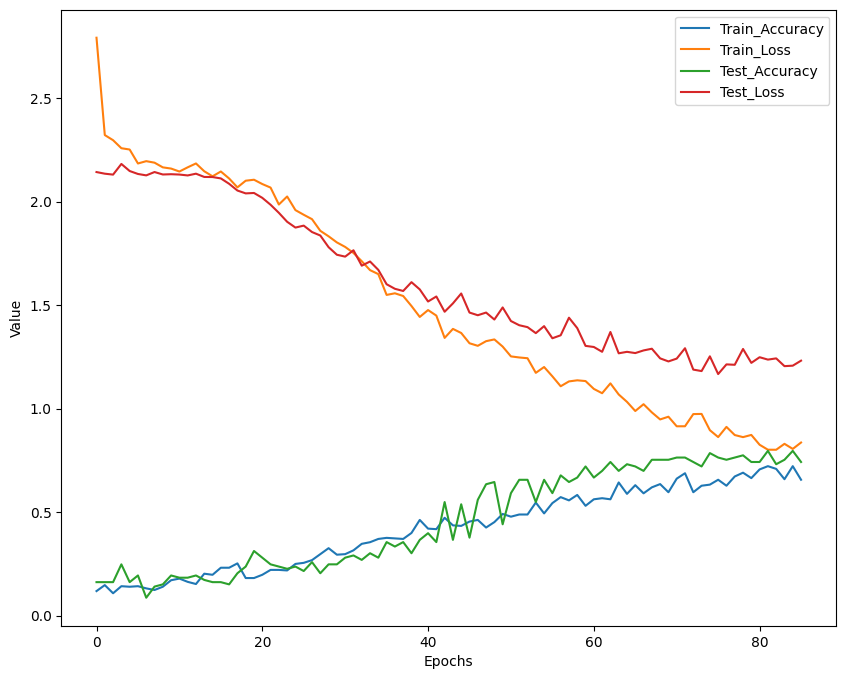

In [10]:
# Show history
history = pd.DataFrame(result.history)

plt.figure(figsize = (10, 8))
plt.plot(range(len(history['accuracy'].values.tolist())), history['accuracy'].values.tolist(), label = 'Train_Accuracy')
plt.plot(range(len(history['loss'].values.tolist())), history['loss'].values.tolist(), label = 'Train_Loss')
plt.plot(range(len(history['val_accuracy'].values.tolist())), history['val_accuracy'].values.tolist(), label = 'Test_Accuracy')
plt.plot(range(len(history['val_loss'].values.tolist())), history['val_loss'].values.tolist(), label = 'Test_Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

3/3 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

           0       0.60      1.00      0.75         6
           1       1.00      0.60      0.75        10
           2       0.57      0.40      0.47        10
           3       1.00      0.70      0.82        10
           4       0.50      0.67      0.57         6
           5       0.80      0.80      0.80        15
           6       0.77      1.00      0.87        10
           7       0.86      0.75      0.80         8
           8       0.80      0.89      0.84        18

    accuracy                           0.76        93
   macro avg       0.77      0.76      0.74        93
weighted avg       0.79      0.76      0.76        93



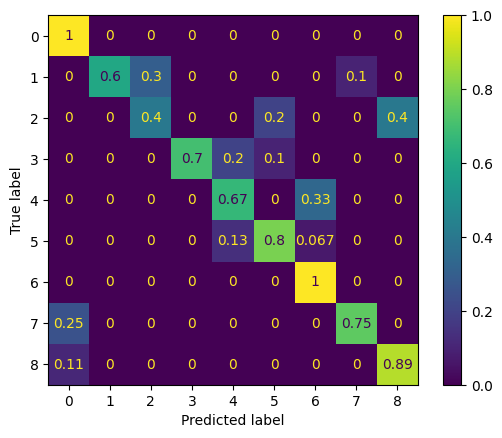

In [11]:
# Predict test data
prediction = np.argmax(model.predict(test_input), 1).flatten()
label = np.argmax(test_output, 1).flatten()

# Confusion matrix
cm = confusion_matrix(label, prediction, normalize='true')
cm = ConfusionMatrixDisplay(cm)
cm.plot()

# Classification report
print(classification_report(label, prediction))

45/45 [==============================] - 12s 244ms/step


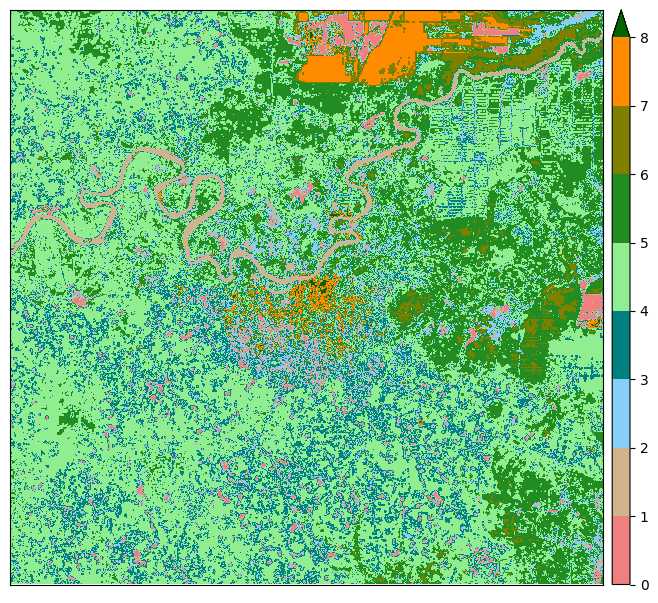

<Axes: >

In [14]:
# Predict image using the model
image_input = []
for x in range(14):
  image_input.append(image.read(x + 1))
# Assuming 'reshape_input' was intended to simply reshape the data,
# we replace it with the appropriate reshaping operation.
# If 'reshape_input' was a custom function, you'll need to define it before this line.
image_input = np.stack(image_input).reshape(14, -1).T

# Ensure the input shape is defined before prediction
image_input = image_input.reshape(image_input.shape[0], -1) # Reshape to (num_samples, num_features)

# Predict
prediction = model.predict(image_input, batch_size=4096*20)
prediction = np.argmax(prediction, 1)
prediction = prediction.reshape(shape[0], shape[1])

# Visualize
cmap, norm = from_levels_and_colors(CLASSES, PALETTE, extend='max')
ep.plot_bands(prediction, cmap=cmap, norm=norm, figsize=plot_size)

In [15]:
# Save file to drive
save_location = '/content/drive/MyDrive/OG_DL/'
name = 'LC_Jambi_2023_points_mlp.tif'
location = save_location + name

new_dataset = rasterio.open(
      location,
      mode='w', driver='GTiff',
      height = prediction.shape[0], width = prediction.shape[1],
      count=1, dtype=str(prediction.dtype),
      crs=crs,
      transform=transform
)
new_dataset.write(prediction, 1);
new_dataset.close()